In [1]:
# !pip install mne

import os
import glob
import numpy as np
import mne
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from google.colab import drive
# drive.mount('/content/drive')
from scipy.io import loadmat
from scipy.signal import butter, lfilter

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne.decoding import CSP
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import tree
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
folder_path=r'D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM'
folder_files=os.listdir(folder_path)
for i in folder_files:
    print(i)

session1_sub10_reaching_realMove.eeg
session1_sub10_reaching_realMove.vhdr
session1_sub10_reaching_realMove.vmrk
session1_sub11_reaching_realMove.eeg
session1_sub11_reaching_realMove.vhdr
session1_sub11_reaching_realMove.vmrk
session1_sub12_reaching_realMove.eeg
session1_sub12_reaching_realMove.vhdr
session1_sub12_reaching_realMove.vmrk
session1_sub13_reaching_realMove.eeg
session1_sub13_reaching_realMove.vhdr
session1_sub13_reaching_realMove.vmrk
session1_sub14_reaching_realMove.eeg
session1_sub14_reaching_realMove.vhdr
session1_sub14_reaching_realMove.vmrk
session1_sub15_reaching_realMove.eeg
session1_sub15_reaching_realMove.vhdr
session1_sub15_reaching_realMove.vmrk
session1_sub16_reaching_realMove.eeg
session1_sub16_reaching_realMove.vhdr
session1_sub16_reaching_realMove.vmrk
session1_sub17_reaching_realMove.eeg
session1_sub17_reaching_realMove.vhdr
session1_sub17_reaching_realMove.vmrk
session1_sub18_reaching_realMove.eeg
session1_sub18_reaching_realMove.vhdr
session1_sub18_reachi

In [3]:
# eeg,vhdr,vmrk = [],[],[]

# for i in folder_files:
#     file=folder_path+'\\'+i
#     if '.eeg' in file:
#         eeg.append(file)
#     elif '.vhdr' in file:
#         vhdr.append(file)
#     else:
#         vmrk.append(file)

# for i in range(0,len(eeg)):
#     print(eeg[i]+'\n'+vhdr[i]+'\n'+vmrk[i]+'\n')

sub = 1
session = 1
eeg = folder_path+'\\'+f'session{session}_sub{sub}_reaching_realMove.eeg'
vhdr = folder_path+'\\'+f'session{session}_sub{sub}_reaching_realMove.vhdr'
vmrk = folder_path+'\\'+f'session{session}_sub{sub}_reaching_realMove.vmrk'

In [4]:
#reading accurately
raw = mne.io.read_raw_brainvision(vhdr, preload=True,eog=['hEOG_L','hEOG_R','vEOG_U','vEOG_D'])
raw.drop_channels(['hEOG_L','hEOG_R','vEOG_U','vEOG_D','EMG_1','EMG_2','EMG_3','EMG_4','EMG_5','EMG_6','EMG_ref'])

Extracting parameters from D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub1_reaching_realMove.vhdr...
Setting channel info structure...
Reading 0 ... 8434299  =      0.000 ...  3373.720 secs...


<RawBrainVision | session1_sub1_reaching_realMove.eeg, 60 x 8434300 (3373.7 s), ~3.77 GB, data loaded>

In [5]:
#take one leave one
raw.resample(sfreq=1250)

<RawBrainVision | session1_sub1_reaching_realMove.eeg, 60 x 4217150 (3373.7 s), ~1.89 GB, data loaded>

In [6]:
#filter
raw.filter(l_freq=8, h_freq=30, method='iir', iir_params=dict(order=4, ftype='butter', output='sos'), phase='zero')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters


---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB



<RawBrainVision | session1_sub1_reaching_realMove.eeg, 60 x 4217150 (3373.7 s), ~1.89 GB, data loaded>

In [8]:
#extract events
events=mne.events_from_annotations(raw)
epoch=mne.Epochs(raw,events[0],event_id=[11, 21, 31, 41, 51, 61],tmin=-0.5,tmax=4,baseline=(-0.5,0))

Used Annotations descriptions: ['Comment/actiCAP Active Shield On', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 21', 'Stimulus/S 31', 'Stimulus/S 41', 'Stimulus/S 51', 'Stimulus/S 61']
Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [9]:
epoch

Number of events,300
Events,11: 5021: 5031: 5041: 5051: 5061: 50
Time range,-0.500 – 4.000 s
Baseline,-0.500 – 0.000 s


In [10]:
event_dict={
 'Forward': 11,
 'Backward': 21,
 'Left': 31,
 'Right': 41,
 'Up': 51,
 'Down': 61,
 'Rest': 8,
}

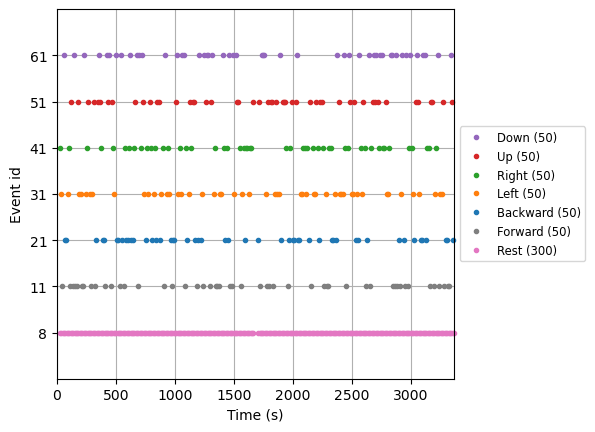

In [11]:
fig=mne.viz.plot_events(events[0],event_id=event_dict,sfreq=raw.info['sfreq'],
                       first_samp=raw.first_samp)

In [12]:
evoked_1=epoch['11'].average()
evoked_2=epoch['21'].average()
evoked_3=epoch['31'].average()
evoked_4=epoch['41'].average()
evoked_5=epoch['51'].average()
evoked_6=epoch['61'].average()
# evoked_7=epoch['8'].average()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [13]:
dicts={
 'Forward': evoked_1,
 'Backward': evoked_2,
#  'Left': evoked_3,
#  'Right': evoked_4,
#  'Up': evoked_5,
#  'Down': evoked_6,
#  'Rest': evoked_7,
}

combining channels using "gfp"
combining channels using "gfp"


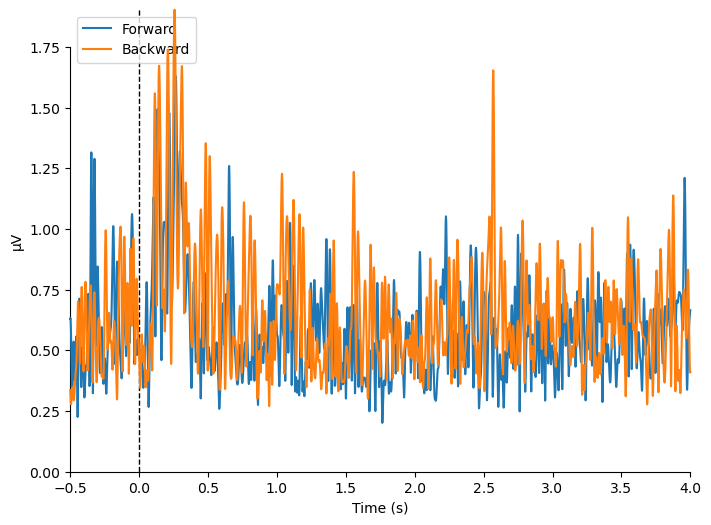

[<Figure size 800x600 with 1 Axes>]

In [14]:
mne.viz.plot_compare_evokeds(dicts,picks=None)


In [15]:
labels=epoch.events[:,-1]
features=epoch.get_data()
features.shape

Using data from preloaded Raw for 300 events and 5626 original time points ...
0 bad epochs dropped


(300, 60, 5626)

In [16]:
import pywt
from pywt import wavedec ,waverec

wavelet = 'db4'
level = 6
# Perform the DWT
coeffs = pywt.wavedec(features, wavelet, level=level)

cA6, cD6, cD5,cD4, cD3, cD2, cD1 =coeffs

In [17]:
from pywt import wavedec ,waverec
for i in range(1, level):
    coeffs[i] = np.zeros_like(coeffs[i])

# Reconstruct the signal from the modified coefficients
filtered_signal = pywt.waverec(coeffs, 'db4')
filtered_signal.shape

(300, 60, 5626)

In [18]:
#dwt finished successfully

# # Calculate the power spectral density of the DWT coefficients
power_spectrum = np.abs(filtered_signal) ** 2

normalized_spectrum = power_spectrum / np.sum(power_spectrum)

normalized_spectrum.shape

(300, 60, 5626)

In [19]:
def resample_with_logvar(z):
    arr = []
    largearr = []
    n=z.shape[2]
    step=10
    for t in range(0,z.shape[0]):
        for i in range(0,n,step): #z.shape[1] =number of samples
            j = i + 2
            arr.append(np.log(np.var(z[t,:,i:j],axis=1)))
        largearr.append(np.array(arr))
    #     z[t] =  arr
        arr=[]

    trials_num=z.shape[0]
    channels_num=largearr[0].shape[1]
    samples_num=largearr[0].shape[0]
    print("largearr",largearr[0].shape)
    final_arr=np.vstack(largearr).reshape(trials_num,channels_num,samples_num)

    return final_arr

In [20]:
normalized_spectrum_logvar=resample_with_logvar(normalized_spectrum)

largearr (563, 60)


In [21]:
normalized_spectrum_logvar.shape

(300, 60, 563)

In [22]:
csp=mne.decoding.CSP(n_components=60)

In [23]:
ex_data=csp.fit_transform(normalized_spectrum_logvar,labels)

Computing rank from data with rank=None
    Using tolerance 8.2e+02 (2.2e-16 eps * 60 dim * 6.2e+16  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.


Computing rank from data with rank=None
    Using tolerance 8.1e+02 (2.2e-16 eps * 60 dim * 6.1e+16  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e+02 (2.2e-16 eps * 60 dim * 6.1e+16  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e+02 (2.2e-16 eps * 60 dim * 6.1e+16  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e+02 (2.2e-16 eps * 60 dim * 6.1e+16  max singular value)


In [24]:
ex_data.shape

(300, 60)

In [25]:
from sklearn.preprocessing import LabelEncoder

In [26]:
lb=LabelEncoder()
nlabels=lb.fit_transform(labels)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(ex_data,nlabels,test_size = 0.2,stratify=labels,shuffle=True)#,stratify=final_label,shuffle=True

In [28]:
X_train.shape

(240, 60)

# LSTM

In [29]:
import tensorflow as tf
def build_model(num_classes):

    inputs = tf.keras.Input(shape=(None, 60))
    x = tf.keras.layers.Reshape((-1, 60))(inputs)
    x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(64)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [30]:
user_model = build_model(num_classes=6)
Epochs=150
user_history = user_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=Epochs,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=3,
#             restore_best_weights=True
#         )
#     ]
)

Epoch 1/150
6/6 [==============================] - 7s 250ms/step - loss: 1.7896 - accuracy: 0.2604 - val_loss: 1.7883 - val_accuracy: 0.2083
Epoch 2/150
6/6 [==============================] - 0s 18ms/step - loss: 1.7823 - accuracy: 0.4688 - val_loss: 1.7813 - val_accuracy: 0.3958
Epoch 3/150
6/6 [==============================] - 0s 17ms/step - loss: 1.7708 - accuracy: 0.6771 - val_loss: 1.7686 - val_accuracy: 0.5000
Epoch 4/150
6/6 [==============================] - 0s 24ms/step - loss: 1.7494 - accuracy: 0.7448 - val_loss: 1.7439 - val_accuracy: 0.7083
Epoch 5/150
6/6 [==============================] - 0s 17ms/step - loss: 1.7114 - accuracy: 0.8021 - val_loss: 1.6987 - val_accuracy: 0.7500
Epoch 6/150
6/6 [==============================] - 0s 17ms/step - loss: 1.6452 - accuracy: 0.8021 - val_loss: 1.6240 - val_accuracy: 0.7708
Epoch 7/150
6/6 [==============================] - 0s 16ms/step - loss: 1.5387 - accuracy: 0.8281 - val_loss: 1.5086 - val_accuracy: 0.7500
Epoch 8/150
6/6 [==

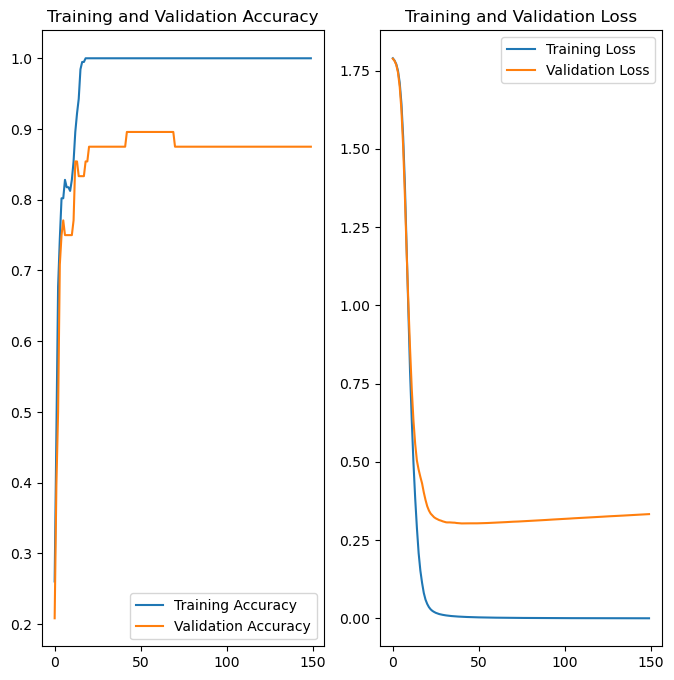

In [31]:
import matplotlib.pyplot as plt
history=user_history
#doctor
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(Epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
user_model.evaluate(X_test, y_test,verbose=0)[1]

0.9166666865348816

# SVM

In [33]:
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay ,confusion_matrix
from sklearn.metrics import accuracy_score

svm_model=SVC(random_state=42)

svm_model.fit(X_train, y_train)

Y_pred = svm_model.predict(X_test)

In [34]:
print("Accuracy = {} ".format(accuracy_score(y_test,Y_pred)))

Accuracy = 0.9166666666666666 


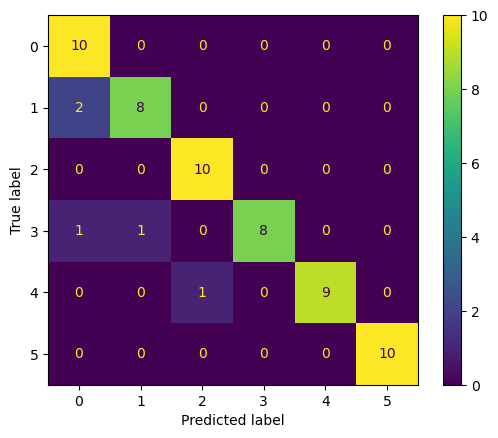

In [35]:
cm=confusion_matrix(y_test,Y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

# MLP(Multi layer perceptron)

In [36]:
from sklearn.neural_network import MLPClassifier

mlp=MLPClassifier(random_state=45)

mlp.fit(X_train,y_train)
Y_pred = mlp.predict(X_test)
print("Accuracy = {} ".format(accuracy_score(y_test,Y_pred)))

Accuracy = 0.95 


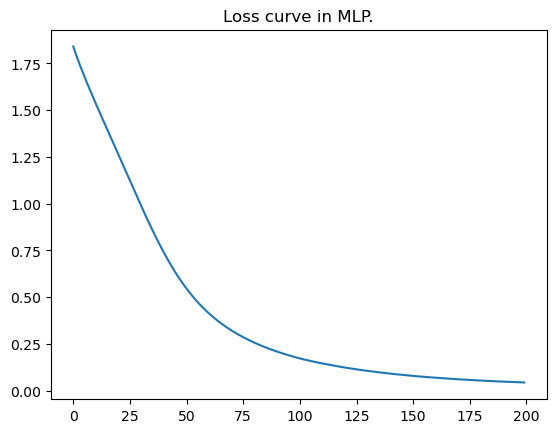

In [37]:
import matplotlib.pyplot as plt

plt.plot(mlp.loss_curve_)
plt.title("Loss curve in MLP.");
plt.show()

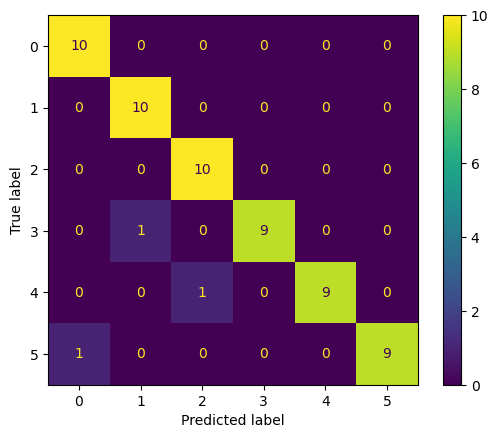

In [38]:
cm=confusion_matrix(y_test,Y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()